In [1]:
import sys
sys.path.append("/home/zhenhao/tc-benchmark") 

In [2]:
from collections import Counter
from ete3 import NCBITaxa
from functools import lru_cache
from tc_benchmark_util import benchmark

ncbi = NCBITaxa()

import pandas as pd

metadata_df = pd.read_csv("/home/zhenhao/metadata_with_taxid.csv", index_col=0)
metadata_df

/tmp/ipykernel_82651/3725458718.py:10: DtypeWarning: Columns (62,64,66,75,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv("/home/zhenhao/metadata_with_taxid.csv", index_col=0)


,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count,genus_name,family_name,species_name,genus_taxid,species_taxid,family_taxid
0,RS_GCF_001206855.1,14,99.60,0.91,761,g__Streptococcus (UID584),238,50.00,1827337,86.246727,...,21,19,35,0,Streptococcus,Streptococcaceae,Streptococcus pneumoniae,1301.0,1313,1300.0
1,RS_GCF_001108865.1,13,99.39,0.34,761,g__Streptococcus (UID584),238,33.33,1852015,86.277715,...,0,19,38,0,Streptococcus,Streptococcaceae,Streptococcus pneumoniae,1301.0,1313,1300.0
2,RS_GCF_000730125.1,30,100.00,0.92,476,f__Bifidobacteriaceae (UID1462),217,0.00,2212698,86.271453,...,619,19,55,0,Bifidobacterium,Bifidobacteriaceae,Bifidobacterium infantis,1678.0,216816,31953.0
3,RS_GCF_000950275.1,0,99.45,0.53,921,f__Vibrionaceae (UID4865),366,0.00,4128151,84.994806,...,0,17,77,1,Photobacterium,Vibrionaceae,Photobacterium angustum,657.0,661,641.0
4,RS_GCF_000468955.1,0,100.00,0.00,472,o__Lactobacillales (UID543),265,0.00,2107260,86.823994,...,0,19,60,0,Lactococcus,Streptococcaceae,Lactococcus cremoris,1357.0,1359,1300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394927,GB_GCA_934776845.1,0,91.57,0.00,149,k__Bacteria (UID2329),89,0.00,779596,89.630474,...,0,19,41,0,UMGS687,UBA1242,UMGS687 sp900544595,NaN,244328,NaN
394928,GB_GCA_023647245.1,4609,99.97,0.13,1162,f__Enterobacteriaceae (UID5121),336,0.00,4707023,87.866887,...,0,19,80,1,Klebsiella,Enterobacteriaceae,Klebsiella pneumoniae,570.0,573,543.0
394929,GB_GCA_020344015.1,0,93.69,3.30,147,k__Bacteria (UID2495),91,0.00,4223673,87.882712,...,27200,18,46,1,G020344215,KS3-K002,G020344215 sp020344015,NaN,2026742,NaN
394930,GB_GCA_945889495.1,0,90.94,3.23,247,c__Deltaproteobacteria (UID3216),155,0.00,4966708,87.941933,...,0,18,46,1,DP-20,UBA9968,DP-20 sp945889495,29526.0,2043168,213465.0


# Check overall accuracy on different taxonomy levels

In [3]:
# Define benchmarking functions
bench = benchmark.kraken2_read_level_benchmark(metadata_df)

In [8]:
# Perform benchmarking
import glob
ground_truth_files = "/mnt/c/Users/zhenh/tax_reads/train_reads.label"
kraken2_reports = glob.glob("/mnt/c/Users/zhenh/kraken2_benchmark/db*_query0.output")

sensitivity = {}
precision = {}
f1 = {}

for rank in ['strain', 'species', 'genus', 'family']:
    sensitivity[rank] = []
    precision[rank] = []
    f1[rank] = []


for report in kraken2_reports:
    kraken2_predictions = aggregate_results(report, ground_truth_files)
    results, _ = check_read_level_predictions(kraken2_predictions)
    # Store the results
    for rank in ['strain', 'species', 'genus', 'family']:

        sensitivity[rank] = sensitivity[rank] + [results[rank + "_sensitivity"]]
        precision[rank] = precision[rank] + [results[rank + "_precision"]]
        f1[rank] = f1[rank] + [2 * results[rank + "_sensitivity"] * results[rank + "_precision"] / (results[rank + "_sensitivity"] + results[rank + "_precision"])]

print(sensitivity)
print(precision)
print(f1)

    
#analyze_kraken_results(kraken2_reports[0], ground_truth_files)

{'strain': [0.6336633663366337, 0.6352051715490499, 0.6233537049765014, 0.5062693886649453, 0.08528226180967065, 0.0007801905894154143], 'species': [0.7570449352627571, 0.7595155387959058, 0.7496702765961399, 0.6353166273475378, 0.12713391414188324, 0.0013188936154403432], 'genus': [0.9578697081715676, 0.9603588876711311, 0.9615105975888396, 0.9363773150298145, 0.5040216967287723, 0.007337506733787825], 'family': [0.9793435253469062, 0.9805881150966879, 0.9806624189623465, 0.9604889194360337, 0.5438485687217878, 0.009120799509594487]}
{'strain': [0.7613096168009463, 0.7429980661842992, 0.7013250292593212, 0.5797983236182614, 0.21049011966438952, 0.055408970976253295], 'species': [0.8730692602669294, 0.8553228876848733, 0.8151447211618089, 0.7055534925939679, 0.297837155663867, 0.09114249037227215], 'genus': [0.986172735618115, 0.9840867992766726, 0.9787463363902807, 0.9441468439782731, 0.6524708428519899, 0.3280730897009967], 'family': [0.9938545063811337, 0.992908868616571, 0.99046904

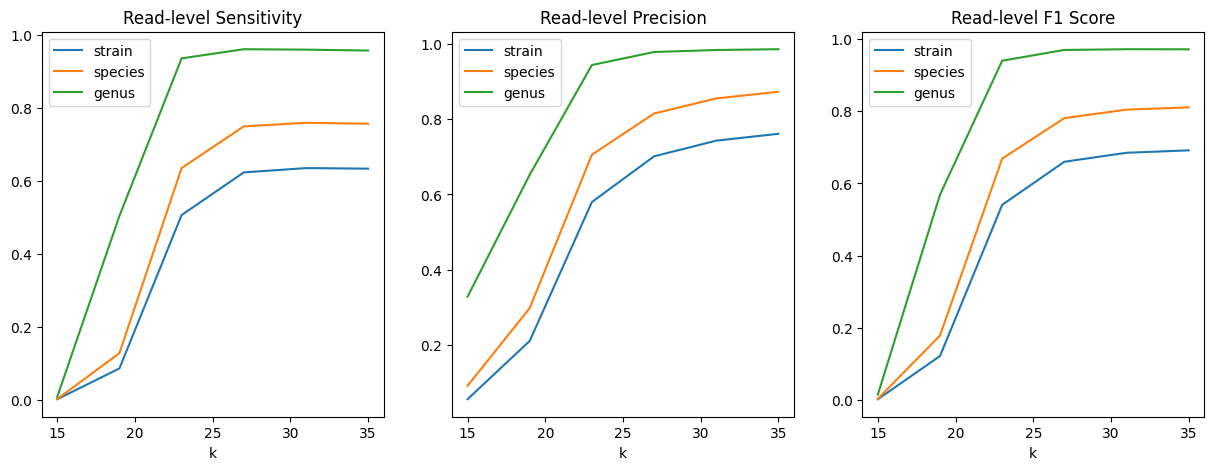

In [20]:
# Plot the results, using 3 subplots showing sensitivity, precision, and F1 score at each level, and value of k on the x-axis

k_values = [15, 19, 23, 27, 31, 35]
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for rank in ['strain', 'species', 'genus']:
    axs[0].plot(k_values, list(reversed(sensitivity[rank])), label=rank)
    axs[1].plot(k_values, list(reversed(precision[rank])), label=rank)
    axs[2].plot(k_values, list(reversed(f1[rank])), label=rank)

axs[0].set_title("Read-level Sensitivity")
axs[1].set_title("Read-level Precision")
axs[2].set_title("Read-level F1 Score")
axs[0].set_xlabel("k")
axs[1].set_xlabel("k")
axs[2].set_xlabel("k")

# Use log plots
axs[0].legend()
axs[1].legend()
axs[2].legend()

# store as pdf
plt.savefig("kraken2_read_level_all.pdf")


# Check the number of assigned k-mers

In [5]:

def LCA_to_dict(LCA):
    res = Counter()
    for item in LCA.split(" "):
        tup = item.split(":")
        try:
            res[int(tup[0])] += int(tup[1])
        except:
            pass
    return res

def check_kmer_predictions(LCA, ground_truth, ground_truth_set=set(), level='genus'):
    prediction = LCA_to_dict(LCA)
    total_number_of_kmers = sum(prediction.values())
    total_kmer_mapped = 0
    kmer_correct_mapped = 0

    if total_number_of_kmers == 0:
        return 0, 0, 0
    
    # Check number of mapped k-mers at the level
    if level == 'strain':
        total_kmer_mapped = sum(prediction[s] for s in prediction if s in ground_truth_set)
    else:
        total_kmer_mapped = sum(prediction[s] for s in prediction if get_level(s, level) is not None)

    # Check the true positives
    if level == 'strain':
        if ground_truth in prediction:
            kmer_correct_mapped = prediction[ground_truth]
    else:
        for prediction_species in prediction:
            if prediction_species != 0:
                if check_equivalence(ground_truth, prediction_species, level):
                    kmer_correct_mapped += prediction[prediction_species]
        
    
    sensitivity = kmer_correct_mapped / total_number_of_kmers if total_kmer_mapped > 0 else 0
    precision = kmer_correct_mapped / total_kmer_mapped if total_kmer_mapped > 0 else 0
    f1 = 2 * sensitivity * precision / (sensitivity + precision) if sensitivity + precision > 0 else 0
    return sensitivity, precision, f1
    



In [6]:
from tqdm import tqdm

def append_kmer_match(kraken2_predict_df):
    for rank in ['strain', 'species', 'genus', 'family']:
        kraken2_predict_df["kmer_sensitivity_" + rank] = np.zeros(len(kraken2_predict_df))
        kraken2_predict_df["kmer_precision_" + rank] = np.zeros(len(kraken2_predict_df))
        kraken2_predict_df["kmer_f1_" + rank] = np.zeros(len(kraken2_predict_df))

    ground_truth_set = set(kraken2_predict_df["ground_truth"])

    for i in tqdm(range(len(kraken2_predict_df))):
        for rank in ['strain', 'species', 'genus', 'family']:
            sensitivity, precision, f1 = check_kmer_predictions(kraken2_predict_df["LCA"][i], kraken2_predict_df["ground_truth"][i], ground_truth_set, rank)
            kraken2_predict_df.loc[i, "kmer_sensitivity_" + rank] = sensitivity
            kraken2_predict_df.loc[i, "kmer_precision_" + rank] = precision
            kraken2_predict_df.loc[i, "kmer_f1_" + rank] = f1


    return kraken2_predict_df

    #return strain_match, species_match, genus_match, family_match

In [7]:
import glob

ground_truth_files = "/mnt/c/Users/zhenh/tax_reads/train_reads.label"
kraken2_reports = glob.glob("/mnt/c/Users/zhenh/kraken2_benchmark1/db*_query0.output")

sensitivity = {'strain': [], 'species': [], 'genus': [], 'family': []}
precision = {'strain': [], 'species': [], 'genus': [], 'family': []}
f1 = {'strain': [], 'species': [], 'genus': [], 'family': []}

for report in kraken2_reports:
    kraken2_predict_df = aggregate_results(report, ground_truth_files)
    append_kmer_match(kraken2_predict_df)
    # Print results and collect the matching information
    for rank in ['strain', 'species', 'genus', 'family']:
        sensitivity[rank] = sensitivity[rank] + [kraken2_predict_df["kmer_sensitivity_" + rank].mean()]
        precision[rank] = precision[rank] + [kraken2_predict_df["kmer_precision_" + rank].mean()]
        f1[rank] = f1[rank] + [kraken2_predict_df["kmer_f1_" + rank].mean()]
    

 88%|████████▊ | 47134/53833 [00:30<00:04, 1647.09it/s]/home/zhenhao/miniconda3/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 147448 was translated into 1281
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
100%|██████████| 53833/53833 [00:28<00:00, 1876.00it/s]


In [8]:
sensitivity

{'strain': [0.06794498535576646,
  0.07368277893518076,
  0.07958623453832962,
  0.0835435677629195,
  0.027875663249602913,
  3.752574969241723e-06],
 'species': [0.10651968110594688,
  0.11635752264554536,
  0.1265545637403763,
  0.13376568235511965,
  0.04578151219974872,
  6.0830314767792986e-06],
 'genus': [0.24234827001043674,
  0.2745495119368714,
  0.31336579320227226,
  0.3565305885914167,
  0.17637652249723446,
  6.659606323100021e-05],
 'family': [0.279470728221119,
  0.3189981704202737,
  0.36787978149663003,
  0.424561170148658,
  0.21942064382602577,
  7.543144644855383e-05]}

In [9]:
precision

{'strain': [0.5717039885954421,
  0.5712969337381147,
  0.562642310679411,
  0.48311258268279245,
  0.18448493478808708,
  0.007081962854590735],
 'species': [0.7356785739059132,
  0.7365343279598829,
  0.7299773785013585,
  0.6461662590872015,
  0.2787054927392536,
  0.012362381006296014],
 'genus': [0.9531580960198921,
  0.9555311352555201,
  0.9572538908441041,
  0.9261395655007174,
  0.615451966156118,
  0.10610640847533515],
 'family': [0.9780570564299365,
  0.9796671330439948,
  0.9808758701062761,
  0.9625771724518436,
  0.6775046436542453,
  0.12459224764529593]}

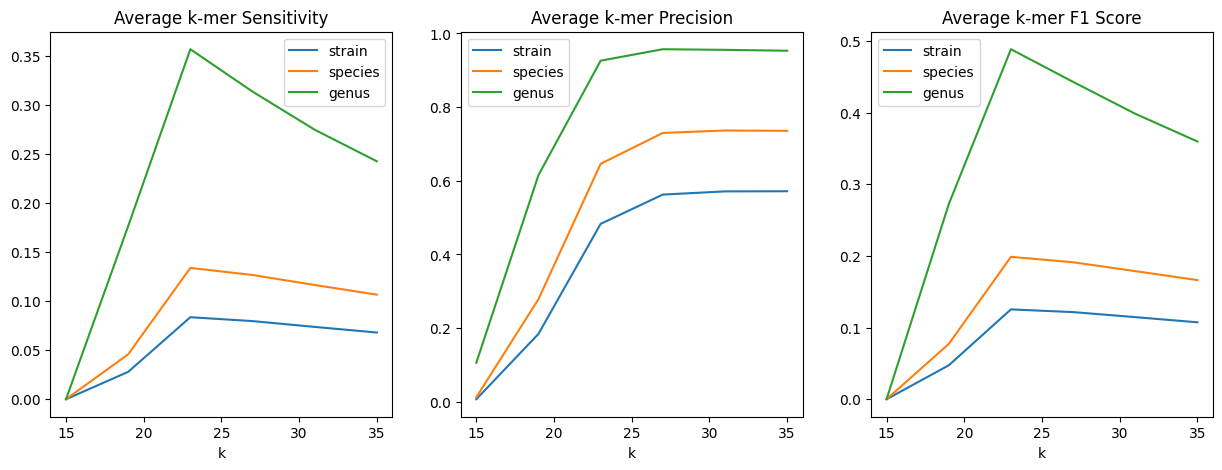

In [11]:
# Plot the results, using 3 subplots showing sensitivity, precision, and F1 score at each level, and value of k on the x-axis

k_values = [15, 19, 23, 27, 31, 35]
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for rank in ['strain', 'species', 'genus']:
    axs[0].plot(k_values, list(reversed(sensitivity[rank])), label=rank)
    axs[1].plot(k_values, list(reversed(precision[rank])), label=rank)
    axs[2].plot(k_values, list(reversed(f1[rank])), label=rank)

axs[0].set_title("Average k-mer Sensitivity")
axs[1].set_title("Average k-mer Precision")
axs[2].set_title("Average k-mer F1 Score")
axs[0].set_xlabel("k")
axs[1].set_xlabel("k")
axs[2].set_xlabel("k")

# Use log plots
axs[0].legend()
axs[1].legend()
axs[2].legend()

# store as pdf
plt.savefig("kraken2_kmer_all.pdf")

# Kraken 2's performance considering read quality

In [83]:
def read_quality(qeury_file):
    """
    Given a fastq query file generated by badread, return a vector containing the read identity of each read.
    This function reads the fastq file, and for each line that starts with "@", and looks like

    `@5e4ec90f-3d44-e1e6-d74e-f6b06ddd8942 NZ_AJWW01000026.1,-strand,106276-110140 length=3834 error-free_length=3885 read_identity=94.375%`

    append the identity `0.94375` into the identity list.
    """
    identity = []
    line_index = 0
    with open(qeury_file, 'r') as f:
        for line in f:
            if line_index % 4 == 0:
                identity.append(float(line.split("=")[-1].strip()[:-1]) / 100)
            line_index += 1
    return identity


def append_read_quality(kraken2_predictions_df, query_file):
    """
    Append the read quality to the kraken2 predictions dataframe.
    """
    identity = read_quality(query_file)
    kraken2_predictions_df["read_identity"] = identity
    return kraken2_predictions_df



In [93]:
ground_truth_files = "/mnt/c/Users/zhenh/tax_reads/train_reads.label"
kraken2_reports = glob.glob("/mnt/c/Users/zhenh/kraken2_benchmark/db*_query0.output")
query_file = "/mnt/c/Users/zhenh/tax_reads/train_reads.fastq"

strain_match = []
species_match = []
genus_match = []
family_match = []

for report in kraken2_reports:
    kraken2_predict_df = aggregate_results(report, ground_truth_files)
    #kraken2_predict_df = append_kmer_match(kraken2_predict_df)
    kraken2_predict_df = append_read_quality(kraken2_predict_df, query_file)

    # Find the sensitivity for high quality reads
    high_quality = kraken2_predict_df[kraken2_predict_df["read_identity"] > 0.98]
    results = check_read_level_predictions(high_quality)
    print(results)


    medium_quality = kraken2_predict_df[(kraken2_predict_df["read_identity"] > 0.92) & (kraken2_predict_df["read_identity"] <= 0.98)]
    results = check_read_level_predictions(medium_quality)
    print(results)


    low_quality = kraken2_predict_df[kraken2_predict_df["read_identity"] <= 0.92]
    results = check_read_level_predictions(low_quality)
    print(results)


100%|██████████| 3110/3110 [00:00<00:00, 85317.55it/s]


{'strain_sensitivity': 0.6893890675241158, 'strain_precision': 0.7979158913286193, 'species_sensitivity': 0.8019292604501608, 'species_precision': 0.8967997123336929, 'genus_sensitivity': 0.9665594855305466, 'genus_precision': 0.9920792079207921, 'family_sensitivity': 0.9845659163987138, 'family_precision': 0.9954486345903771}


100%|██████████| 44178/44178 [00:00<00:00, 85940.42it/s]


{'strain_sensitivity': 0.6449816650821676, 'strain_precision': 0.7636275928605886, 'species_sensitivity': 0.7667391009099552, 'species_precision': 0.8735107535200372, 'genus_sensitivity': 0.9607723301190638, 'genus_precision': 0.9866111898840101, 'family_sensitivity': 0.9806238399203223, 'family_precision': 0.9939202055658798}


100%|██████████| 6545/6545 [00:00<00:00, 87133.10it/s]


{'strain_sensitivity': 0.5307868601986249, 'strain_precision': 0.7228464419475655, 'species_sensitivity': 0.6702826585179527, 'species_precision': 0.8568359375, 'genus_sensitivity': 0.93414820473644, 'genus_precision': 0.9802789802789803, 'family_sensitivity': 0.9682200152788388, 'family_precision': 0.9926378446115288}


100%|██████████| 3110/3110 [00:00<00:00, 84214.82it/s]


{'strain_sensitivity': 0.682636655948553, 'strain_precision': 0.7802278574053657, 'species_sensitivity': 0.8016077170418007, 'species_precision': 0.8846699787083038, 'genus_sensitivity': 0.9668810289389067, 'genus_precision': 0.9891447368421052, 'family_sensitivity': 0.9845659163987138, 'family_precision': 0.9951251218719532}


100%|██████████| 44178/44178 [00:00<00:00, 82718.83it/s]


{'strain_sensitivity': 0.6457739146181357, 'strain_precision': 0.7480269540365505, 'species_sensitivity': 0.7675087147448957, 'species_precision': 0.8576885133938734, 'genus_sensitivity': 0.962424736294083, 'genus_precision': 0.9850794680506001, 'family_sensitivity': 0.9811218253429309, 'family_precision': 0.9930351906158358}


100%|██████████| 6545/6545 [00:00<00:00, 87771.07it/s]


{'strain_sensitivity': 0.5413292589763178, 'strain_precision': 0.6862289366647298, 'species_sensitivity': 0.6855614973262032, 'species_precision': 0.8230007336757154, 'genus_sensitivity': 0.9433155080213904, 'genus_precision': 0.9748934154429181, 'family_sensitivity': 0.9750954927425516, 'family_precision': 0.9909937888198758}


100%|██████████| 3110/3110 [00:00<00:00, 86324.83it/s]


{'strain_sensitivity': 0.6797427652733119, 'strain_precision': 0.751778093883357, 'species_sensitivity': 0.7958199356913184, 'species_precision': 0.8549222797927462, 'genus_sensitivity': 0.9697749196141479, 'genus_precision': 0.9882044560943644, 'family_sensitivity': 0.9845659163987138, 'family_precision': 0.9938331710483609}


100%|██████████| 44178/44178 [00:00<00:00, 84352.73it/s]


{'strain_sensitivity': 0.633007379238535, 'strain_precision': 0.7079567605883396, 'species_sensitivity': 0.7574358277875866, 'species_precision': 0.8198657323467438, 'genus_sensitivity': 0.962560550500249, 'genus_precision': 0.9800414842129523, 'family_sensitivity': 0.9809407397347096, 'family_precision': 0.990899528970595}


100%|██████████| 6545/6545 [00:00<00:00, 70900.05it/s]


{'strain_sensitivity': 0.531398013750955, 'strain_precision': 0.6283649503161698, 'species_sensitivity': 0.6753246753246753, 'species_precision': 0.7620689655172413, 'genus_sensitivity': 0.9504965622612681, 'genus_precision': 0.9655440012416576, 'family_sensitivity': 0.9769289533995417, 'family_precision': 0.9859676175790285}


100%|██████████| 3110/3110 [00:00<00:00, 83850.49it/s]


{'strain_sensitivity': 0.5977491961414791, 'strain_precision': 0.6774781341107872, 'species_sensitivity': 0.7163987138263666, 'species_precision': 0.7864454641722556, 'genus_sensitivity': 0.9598070739549839, 'genus_precision': 0.9704161248374512, 'family_sensitivity': 0.9816720257234727, 'family_precision': 0.9861111111111112}


100%|██████████| 44178/44178 [00:00<00:00, 84467.28it/s]


{'strain_sensitivity': 0.5243333786047354, 'strain_precision': 0.5984138055749308, 'species_sensitivity': 0.6548508307302278, 'species_precision': 0.7244816187518782, 'genus_sensitivity': 0.9492507582959844, 'genus_precision': 0.9574429223744292, 'family_sensitivity': 0.9731766942822219, 'family_precision': 0.9776691301876066}


100%|██████████| 6545/6545 [00:00<00:00, 85021.96it/s]


{'strain_sensitivity': 0.3408708938120703, 'strain_precision': 0.40176481181343415, 'species_sensitivity': 0.4649350649350649, 'species_precision': 0.5330180416885619, 'genus_sensitivity': 0.8383498854087089, 'genus_precision': 0.842339576297206, 'family_sensitivity': 0.8647822765469825, 'family_precision': 0.8678319533885311}


100%|██████████| 3110/3110 [00:00<00:00, 81162.06it/s]


{'strain_sensitivity': 0.13987138263665594, 'strain_precision': 0.3904847396768402, 'species_sensitivity': 0.22733118971061092, 'species_precision': 0.5566929133858268, 'genus_sensitivity': 0.672347266881029, 'genus_precision': 0.8531211750305998, 'family_sensitivity': 0.7418006430868167, 'family_precision': 0.8689265536723164}


100%|██████████| 44178/44178 [00:00<00:00, 83481.65it/s]


{'strain_sensitivity': 0.09081443252297523, 'strain_precision': 0.2235222017939718, 'species_sensitivity': 0.13366381456833717, 'species_precision': 0.3122851552170924, 'genus_sensitivity': 0.5148263841731179, 'genus_precision': 0.6666080483015329, 'family_sensitivity': 0.5554121961157137, 'family_precision': 0.6864456567352077}


100%|██████████| 6545/6545 [00:00<00:00, 79140.78it/s]


{'strain_sensitivity': 0.022001527883880826, 'strain_precision': 0.05272793848407177, 'species_sensitivity': 0.03544690603514133, 'species_precision': 0.08285714285714285, 'genus_sensitivity': 0.3511077158135982, 'genus_precision': 0.45822532402791627, 'family_sensitivity': 0.37173414820473644, 'family_precision': 0.47160302384182984}


100%|██████████| 3110/3110 [00:00<00:00, 83656.90it/s]


{'strain_sensitivity': 0.0009646302250803858, 'strain_precision': 0.08333333333333333, 'species_sensitivity': 0.0022508038585209, 'species_precision': 0.175, 'genus_sensitivity': 0.0077170418006430866, 'genus_precision': 0.38095238095238093, 'family_sensitivity': 0.011897106109324759, 'family_precision': 0.4805194805194805}


100%|██████████| 44178/44178 [00:00<00:00, 84235.12it/s]


{'strain_sensitivity': 0.0007922495359681289, 'strain_precision': 0.05672609400324149, 'species_sensitivity': 0.0013581420616596495, 'species_precision': 0.0949367088607595, 'genus_sensitivity': 0.007537688442211055, 'genus_precision': 0.34365325077399383, 'family_sensitivity': 0.009190094617230296, 'family_precision': 0.38301886792452833}


100%|██████████| 6545/6545 [00:00<00:00, 85627.94it/s]

{'strain_sensitivity': 0.0006111535523300229, 'strain_precision': 0.0380952380952381, 'species_sensitivity': 0.0006111535523300229, 'species_precision': 0.037383177570093455, 'genus_sensitivity': 0.005805958747135217, 'genus_precision': 0.22093023255813954, 'family_sensitivity': 0.007333842627960275, 'family_precision': 0.25396825396825395}


In [88]:
high_quality = kraken2_predict_df[kraken2_predict_df["read_identity"] > 0.98]
high_quality

,classified,read_id,classification_result,read_length,LCA,ground_truth,read_identity
9,C,5e2721e0-ac97-1434-35aa-cdd6417c6c03,1177926,1429,0:9 1386:34 0:28 1386:112 0:9 1386:1 0:66 1386...,1177926,0.98277
25,C,3c0ae429-095b-a833-2e33-4016172fdf1c,185979,1217,0:5 1386:33 0:24 1386:45 185979:5 1386:56 0:27...,1177926,0.98135
27,C,45c13c43-4139-95e7-c3e4-caf46118daa0,1177926,4669,0:25 1386:10 0:2 1386:9 0:8 1386:1 0:13 1386:4...,1177926,0.98621
31,C,38daea44-adb5-86f5-0dbe-676e7e18637a,1177926,3376,0:53 1177926:3 1386:5 1177926:21 1386:105 1177...,1177926,0.98649
45,C,55e2d858-ce8b-2a2b-da2d-9ad882d54c24,185979,1985,0:53 1386:4 0:13 1386:1 0:7 1386:5 0:3 1386:76...,1177926,0.98116
...,...,...,...,...,...,...,...
53745,C,88c975fd-9dc7-378b-a9dd-ccba571224af,2912228,4068,0:38 1279:8 0:33 1279:59 0:50 1279:18 0:53 127...,1288,0.98002
53763,C,dc09014e-3f61-f51c-f1b3-a8204b014b14,1353979,9616,0:4 1279:11 1288:5 1279:1 1288:1 1279:3 1288:1...,1353979,0.98248
53766,C,7153f9ef-847d-7fc7-d897-4105ed8ba5c1,1353979,3259,0:16 1279:4 0:29 1288:6 0:32 1288:14 1279:26 1...,1353979,0.98511
53783,C,57f554c6-1511-d8a1-a930-90cf9f28137d,1353979,3714,0:4 1353979:11 1288:23 1279:3 1288:31 0:5 1279...,1353979,0.98320


# Check the performance of different genera

In [128]:
def append_ground_truth(kraken2_predict_df, level='genus'):
    if level == 'strain':
        kraken2_predict_df["ground_truth_strain"] = kraken2_predict_df["ground_truth"]
        return kraken2_predict_df
    else:
        ground_truth_at_level = []
        for i in range(len(kraken2_predict_df)):
            ground_truth_at_level.append(get_level(kraken2_predict_df.loc[i, "ground_truth"], level))
        kraken2_predict_df["ground_truth_" + level] = ground_truth_at_level
        return kraken2_predict_df

def check_result_at_level(kraken2_predict_df, level='genus', checking_level='species', threshold = 5):
    # Check the results at the level
    kraken2_predict_df = append_ground_truth(kraken2_predict_df, level)
    kraken2_predict_df = append_ground_truth(kraken2_predict_df, checking_level)
    kraken2_predict_df = kraken2_predict_df.dropna()

    # Group the dataframe by ground_truth_`level`, and count the unique values in ground_truth_`checking_level`
    grouped_count_df = kraken2_predict_df.groupby("ground_truth_" + level)["ground_truth_" + checking_level].nunique()

    res = []

    for item in set(kraken2_predict_df["ground_truth_" + level]):
        results = check_read_level_predictions(kraken2_predict_df[kraken2_predict_df["ground_truth_" + level] == item])
        sensitivity = results[checking_level + "_sensitivity"]
        precision = results[checking_level + "_precision"]
        f1 = 2 * sensitivity * precision / (sensitivity + precision) if sensitivity + precision > 0 else 0
        if grouped_count_df.loc[item] > threshold:

            res.append((grouped_count_df.loc[item], sensitivity, precision, f1))

    return res
    




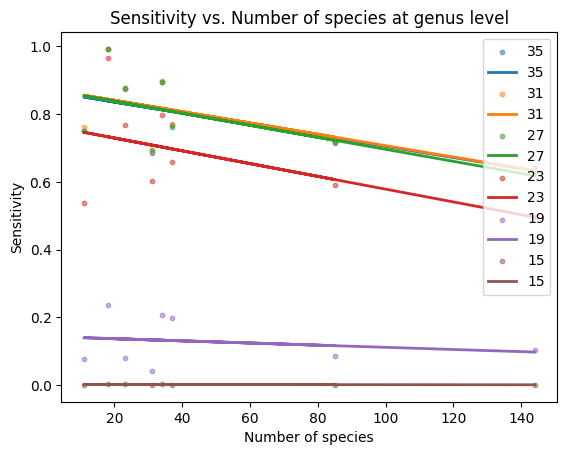

In [132]:
import numpy as np
from sklearn.linear_model import LinearRegression

ground_truth_files = "/mnt/c/Users/zhenh/tax_reads/train_reads.label"
kraken2_reports = glob.glob("/mnt/c/Users/zhenh/kraken2_benchmark/db*_query0.output")
query_file = "/mnt/c/Users/zhenh/tax_reads/train_reads.fastq"

strain_match = []
species_match = []
genus_match = []
family_match = []

# Plot all scatter plots in one plot


# Plot all scatter plots in one plot
k_values = list(reversed([15, 19, 23, 27, 31, 35]))
index = 0
for report in kraken2_reports:
    kraken2_predict_df = aggregate_results(report, ground_truth_files)

    res = check_result_at_level(kraken2_predict_df, 'genus', 'species')

    x = np.array([item[0] for item in res]).reshape(-1, 1)
    y = np.array([item[1] for item in res])

    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    plt.scatter(x, y, label=k_values[index], alpha=0.5, s=10)
    plt.plot(x, y_pred, label=k_values[index], linewidth=2)
    index += 1

plt.xlabel("Number of species")
plt.ylabel("Sensitivity")
plt.title("Sensitivity vs. Number of species at genus level")
plt.legend()
plt.show()



{nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 2803850.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 286.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 n

In [101]:
kraken2_predict_df.dropna()

,classified,read_id,classification_result,read_length,LCA,ground_truth,ground_truth_genus
0,C,5e4ec90f-3d44-e1e6-d74e-f6b06ddd8942,1177926,3834,0:44 185979:4 1386:5 0:1 1386:4 0:6 1386:1 0:8...,1177926,1386.0
1,C,b13ed618-56b9-5dbe-ed27-12d85d101587,1177926,3847,0:1 1408:4 1386:18 185979:5 1386:7 185979:1 13...,1177926,1386.0
2,C,cce0001f-c295-9644-4f74-0e62115d8598,1177926,4572,0:15 1177926:1 0:5 1177926:1 0:30 1386:6 0:60 ...,1177926,1386.0
3,C,e77d2301-6111-5f04-a094-ce636b6d1449,1177926,8550,0:240 1386:15 0:86 1386:9 0:698 1386:3 0:431 1...,1177926,1386.0
4,C,7b2215a5-5638-ecf9-488b-d8c9009fb330,185979,6961,0:84 1386:18 0:55 1386:23 0:73 1386:11 185979:...,1177926,1386.0
...,...,...,...,...,...,...,...
53828,C,0617b054-6d7c-77c7-0138-53632ee5ead4,1353979,3157,0:107 1288:5 1279:10 0:45 1288:12 0:40 1353979...,1353979,1279.0
53829,C,4828fd69-acc2-df2e-2869-f9af80fafc02,1353979,6014,0:42 1353979:7 0:3 1353979:5 0:23 1279:1 0:15 ...,1353979,1279.0
53830,C,1684f5eb-7131-8506-9e88-ed556acaa55c,1353979,2815,0:35 1279:23 1288:14 0:9 1288:5 0:49 135621:2 ...,1353979,1279.0
53831,C,06958cbf-a2ff-049f-d15b-739572efb77d,1353979,1472,0:51 1279:9 0:7 1279:5 0:3 1288:5 0:42 1279:5 ...,1353979,1279.0


In [109]:
kraken2_predict_df.groupby("ground_truth_genus").count().loc[286.0, "classified"]

4329